# Non-Ergodic GMM Regression (Type-2) using INLA
## Spatially Uncorrelated Anelastic Attenuation Cells

This notebook is used to estimate the non-ergodic coefficients, anelastic attenuation coefficients, and hyper-parameters of a type-2 non-ergodic GMM though Gaussian Process regression using the Bayesian software INLA. 

The Type-2 GMM compnents, with uncorrelated anelastic attenuation cells, are:
- The non-ergodic effects are modeled by:
  - $\delta c_{0}$:    constant shift of non-ergodic GMM with respect to base ergodic GMM
  - $\delta c_{1,e}$:  spatially varying eathquake adjustment as a function of the earthquake coordinates
  - $\delta c_{1a,s}$: spatially varying site adjustment as a function of the site coordinates
  - $\delta c_{1b,s}$: spatially independent site adjustment as a function of the station id
  - $c_{ca,p}$:        cell-specific anelastic attenuation
- The aleatory variability is captured by:
  - $\delta B^0_{e}$: between-event aleatory term
  - $\delta W^0_{e,s}$: within-event aleatory term
- The non-ergodic hyperparameters are:
  - $\ell_{1,e}$:     correlation lenght of spatially varying earthquake adjustment
  - $\ell_{1a,s}$:    correlation lenght of spatially varying site adjustment
  - $\omega_{1,e}$:   scale of spatially varying earthquake adjustment 
  - $\omega_{1a,s}$:  scale of spatially varying site adjustment
  - $\omega_{1b,s}$:  scale of spatially independent site adjustment
  - $\omega_{ca,p}$:  scale of anelastic attenuation cell coefficients
  - $\tau_{0}$:       standard deviation of between-event aleatory
  - $\phi_{0}$:       standard deviation of within-event aleatory

**Disclaimer:** The non-ergodic regression is perfomed on the total residuals (column ``res_name``) of a base ergodic GMM without including the effect of anelastic attenuation. 
The total ergodic residuals ($e'_{tot}$) without the effect of anelastic attenuation are defined as:
$$
e'_{tot} = log(IM) - ((\mu_{erg}(M,R_{rup},V_{S30}, ...) - c_{a~erg} ~ R_{rup})
$$
where $IM$ is the intesity parameter of interest (e.g. PGA, PSA), $\mu_{erg}$ is mean functional form of the ergodic GMM in log space, and $c_{a~erg}$ is the ergodic anelastic attenuation coefficient.

## Load required functions

In [1]:
#user functions
source('../R_lib/regression/inla/regression_inla_model2_uncorr_cells_unbounded_hyp.R')

rgdal: version: 1.5-23, (SVN revision 1121)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.0.4, released 2020/01/28
Path to GDAL shared files: /home/glavrent/anaconda3/envs/python_3.8/share/gdal
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 6.3.1, February 10th, 2020, [PJ_VERSION: 631]
Path to PROJ shared files: /home/glavrent/anaconda3/envs/python_3.8/share/proj
Linking to sp version:1.4-5
To mute warnings of possible GDAL/OSR exportToProj4() degradation,
use options("rgdal_show_exportToProj4_warnings"="none") before loading rgdal.

Loading required package: spam

Loading required package: dotCall64

Loading required package: grid

Spam version 2.7-0 (2021-06-25) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The

## User Input, Definition of Regression Parameters 
_The 1st synthetic dataset based on the North CA NGAWest2 is used as an example; however, the user should update the variables in this section to point to the dataset of interest._

In [2]:
#regression name
reg_name  <- 'example_regression_ds2_inla'

#regression dataset
flatfile_fname <- '../../Data/Verification/synthetic_datasets/ds2_small_corr_len/CatalogNGAWest3CALite_synthetic_data_small_corr_len_Y1.csv'
#cell-path info and distance matrix
cellinfo_fname <- '../../Data/Verification/synthetic_datasets/ds2_small_corr_len/CatalogNGAWest3CALite_cellinfo.csv'
celldist_fname <- '../../Data/Verification/synthetic_datasets/ds2_small_corr_len/CatalogNGAWest3CALite_distancematrix.csv'

#output directory
dir_out <- '../../Data/Regression/example_ds2_inla/'

#INLA regression parameters
runinla_flag <- TRUE # TRUE or FALSE
res_name     <- 'tot'

#mesh coarseness
# #fine
# mesh_edge_max     <- 5
# mesh_inner_offset <- 15
# mesh_outer_offset <- 15
# #medium
# mesh_edge_max     <- 15
# mesh_inner_offset <- 15
# mesh_outer_offset <- 50
#coarse
mesh_edge_max     <- 50
mesh_inner_offset <- 50
mesh_outer_offset <- 150

#ergodic coefficients
c_a_erg <- 0.0 #anelastic attenuation

#approximation options
# if flag_gp_approx=TRUE uses int.strategy="eb" and strategy="gaussian"
# int.strategy="eb" corresponds to one integration point, and 
# strategy="gaussian" approximates posteriors as gaussian distributions
flag_gp_approx <- TRUE # TRUE or FALSE

#number of threads
# reduce number of threads if running out of memmory, if not specified
# number of CPU threads is used
n_threads <- 8

## Load Files

In [3]:
#load flatfile
df_flatfile  <- read.csv(flatfile_fname)

#load cell dataframes
df_cellinfo  <- read.csv(cellinfo_fname)
df_celldist  <- read.csv(celldist_fname)

## Preprocessing 
This section can be used by the user for any pre-porcessing of their dataset.

## Run Regression

In [4]:
print(paste("Running regression for: ",reg_name))

#run time start
run_t_strt <- Sys.time()

#run INLA model
RunINLA(df_flatfile, df_cellinfo, df_celldist, reg_name, dir_out, res_name=res_name, 
        c_a_erg=c_a_erg,
        runinla_flag=runinla_flag,
        mesh_edge_max=mesh_edge_max, 
        mesh_inner_offset=mesh_inner_offset, mesh_outer_offset=mesh_outer_offset,
        flag_gp_approx=flag_gp_approx,
        n_threads=n_threads)

#run time end
run_t_end <- Sys.time()

#compute run time
run_tm <- run_t_end - run_t_strt

#log run time
df_run_info <- data.frame(computer_name=Sys.info()["nodename"], reg_name=reg_name, run_time=run_tm)

#write out run info
write.csv(df_run_info, sprintf('%s/run_info.csv', dir_out), row.names=FALSE)

print(paste("Completed regression for: ",reg_name))

[1] "Running regression for:  example_regression_ds2_inla"
[1] "max R_rup misfit 1.76214598468505e-12"


Warning message in inla.model.properties.generic(inla.trim.family(model), mm[names(mm) == :
“Model 'z' in section 'latent' is marked as 'experimental'; changes may appear at any time.
  Use this model with extra care!!! Further warnings are disabled.”
Warning message in `[<-.data.frame`(`*tmp*`, "dc_0", , value = structure(list(mean = -0.0488384440541267, :
“provided 7 variables to replace 6 variables”
Warning message in `[<-.data.frame`(`*tmp*`, "mu_cap", , value = structure(list(:
“provided 7 variables to replace 6 variables”
Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] NA

[1] "Completed regression for:  example_regression_ds2_inla"


## Regression Review
The next code chunks produce summary plots to review the regression fit

In [5]:
#load non-ergodic coefficients, residuals, and cell specific anelastic attenuation
fname_gmotion <- file.path(dir_out, paste0(reg_name,'_inla_residuals.csv'))
fname_coeff   <- file.path(dir_out, paste0(reg_name,'_inla_coefficients.csv'))
fname_atten   <- file.path(dir_out, paste0(reg_name,'_inla_catten.csv'))
df_gmotion <- read.csv(fname_gmotion)
df_coeff   <- read.csv(fname_coeff)
df_atten   <- read.csv(fname_atten)

#merge gm-flatfile with non-ergodic coeffs and res 
df_gmotion <- merge(df_flatfile,df_gmotion)
df_coeff   <- merge(df_flatfile,df_coeff)
#merge cell atten coeffs with cell atten info
df_atten   <- merge(df_cellinfo, df_atten)

#print mean and standard deviations of aleatory terms
fprintf('Between-event mean:\t %.3f\n', mean(df_gmotion$res_between))
fprintf('Within-event mean:\t %.3f\n',  mean(df_gmotion$res_within))
fprintf('Between-event std:\t %.3f\n',  sd(df_gmotion$res_between))
fprintf('Within-event std:\t %.3f\n',   sd(df_gmotion$res_within))

Between-event mean:	 -0.001
Within-event mean:	 -0.000
Between-event std:	 0.308
Within-event std:	 0.395


### Non-ergodic residuals

Warning message:
“Computation failed in `stat_smooth()`:
workspace required (37181620834) is too large probably because of setting 'se = TRUE'.”
Warning message:
“Computation failed in `stat_smooth()`:
workspace required (37181620834) is too large probably because of setting 'se = TRUE'.”


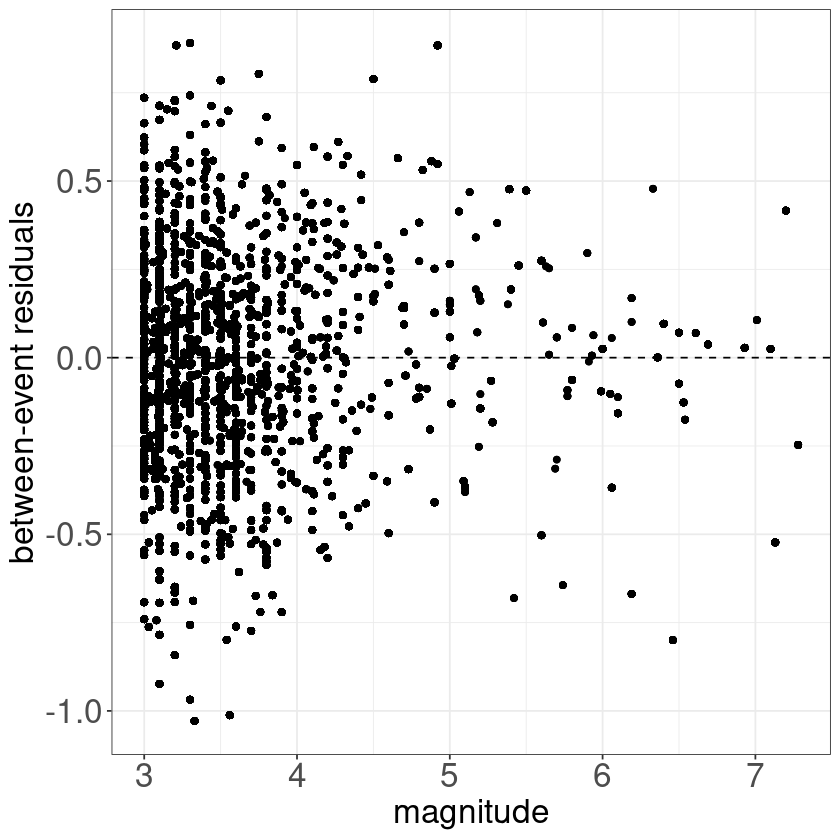

Warning message:
“Computation failed in `stat_smooth()`:
workspace required (37181620834) is too large probably because of setting 'se = TRUE'.”


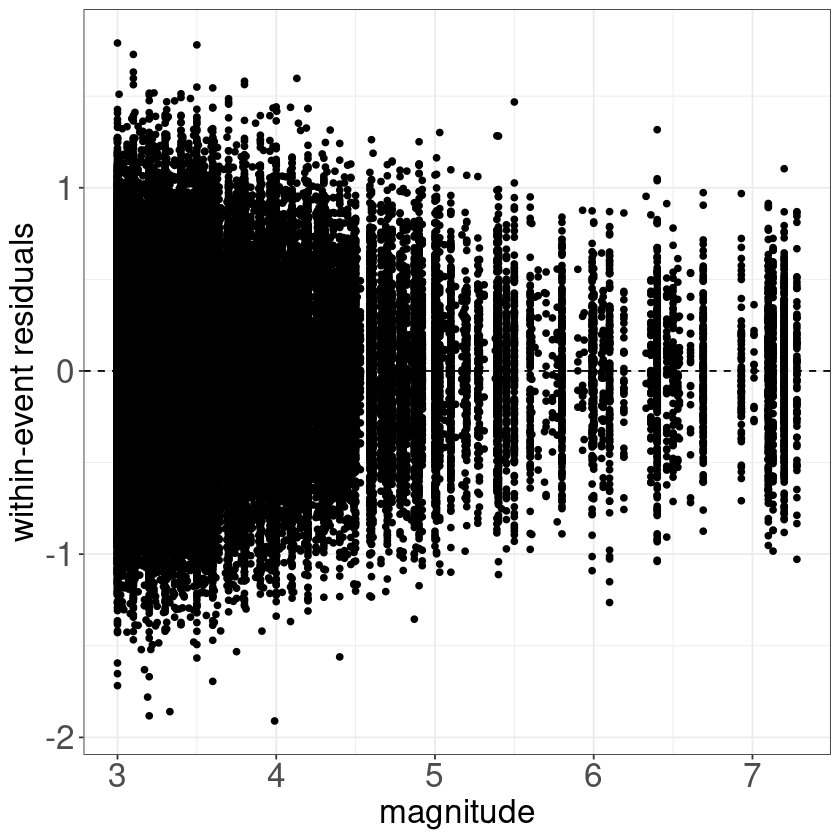

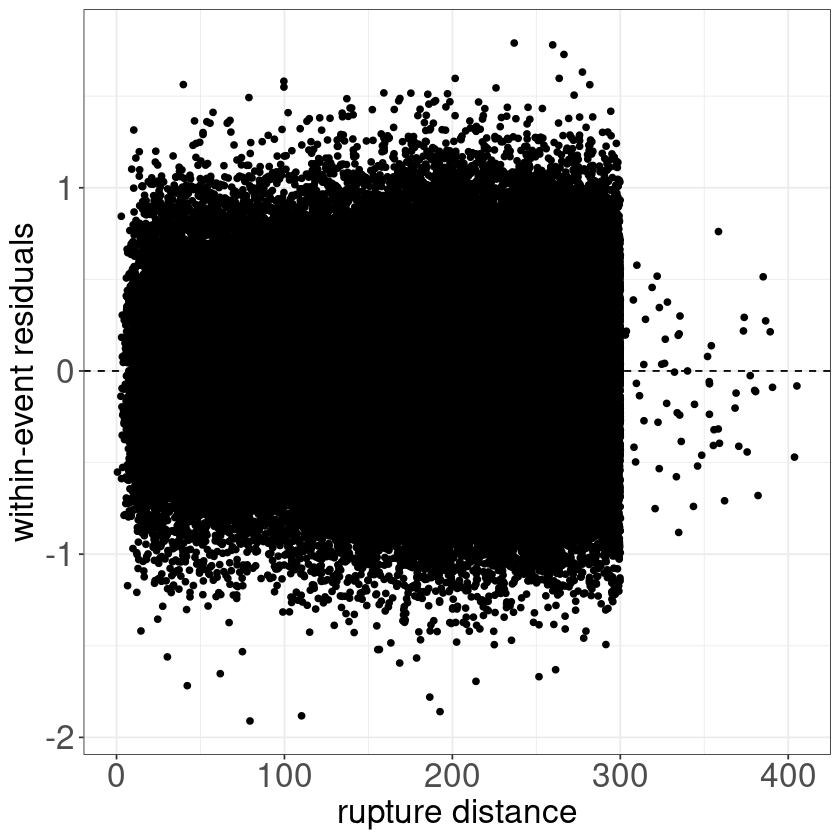

In [6]:
#between-event residuals 
pl_dB_mag <- ggplot(df_gmotion, aes(mag, res_between)) + theme_bw() +
              geom_point() + geom_hline(yintercept=0,linetype="dashed") +
              geom_smooth(se = TRUE, formula = y ~ x, method = 'loess') +
              labs(x='magnitude', y='between-event residuals') + 
              theme(axis.title = element_text(size=20), 
                    axis.text.y = element_text(size=20), axis.text.x = element_text(size=20))

#within-event residuals 
pl_dW_mag <- ggplot(df_gmotion, aes(mag, res_within)) + theme_bw() +
              geom_point() + geom_hline(yintercept=0,linetype="dashed") +
              geom_smooth(se = TRUE, formula = y ~ x, method = 'loess') +
              labs(x='magnitude', y='within-event residuals') + 
              theme(axis.title = element_text(size=20), 
                    axis.text.y = element_text(size=20), axis.text.x = element_text(size=20))

pl_dW_Rrup <- ggplot(df_gmotion, aes(Rrup, res_within)) + theme_bw() +
               geom_point() + geom_hline(yintercept=0,linetype="dashed") +
               geom_smooth(se = TRUE, formula = y ~ x, method = 'loess') +
               labs(x='rupture distance', y='within-event residuals') + 
               theme(axis.title = element_text(size=20), 
                     axis.text.y = element_text(size=20), axis.text.x = element_text(size=20))

print(pl_dB_mag)
print(pl_dW_mag)
print(pl_dW_Rrup)

### Non-ergodic Coefficients

Warning message:
“Computation failed in `stat_smooth()`:
workspace required (37181620834) is too large probably because of setting 'se = TRUE'.”
Warning message:
“Computation failed in `stat_smooth()`:
workspace required (37181620834) is too large probably because of setting 'se = TRUE'.”


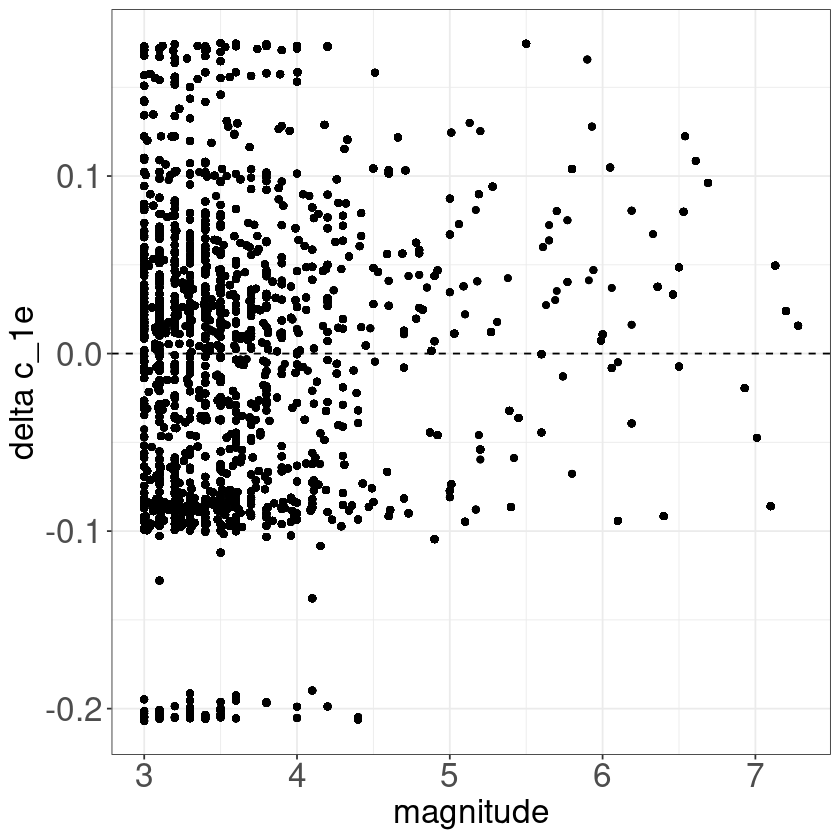

Warning message:
“Computation failed in `stat_smooth()`:
workspace required (37181620834) is too large probably because of setting 'se = TRUE'.”


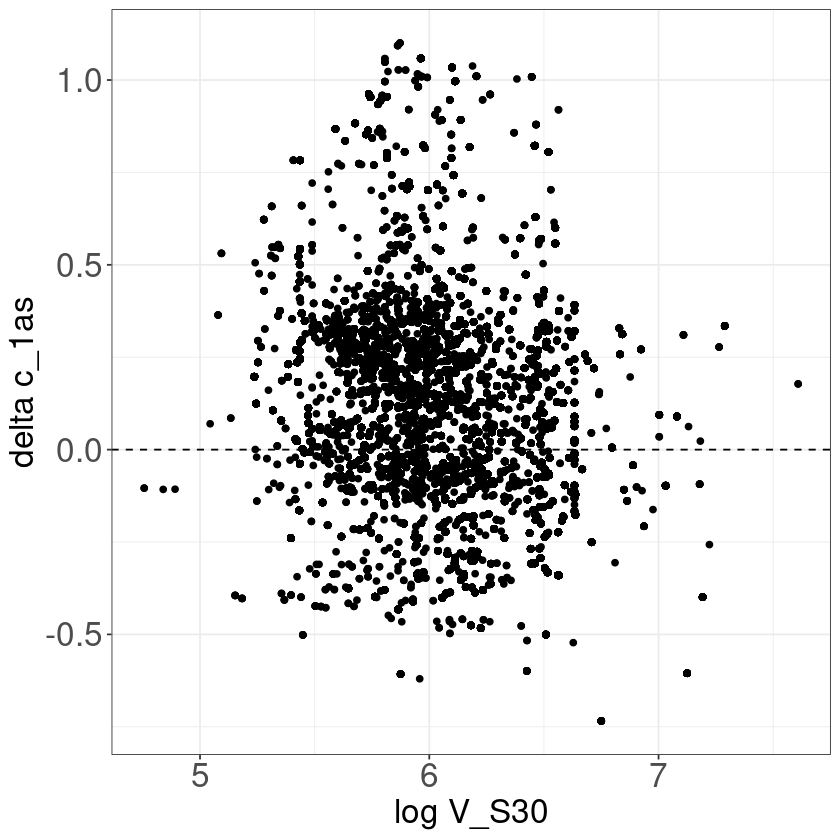

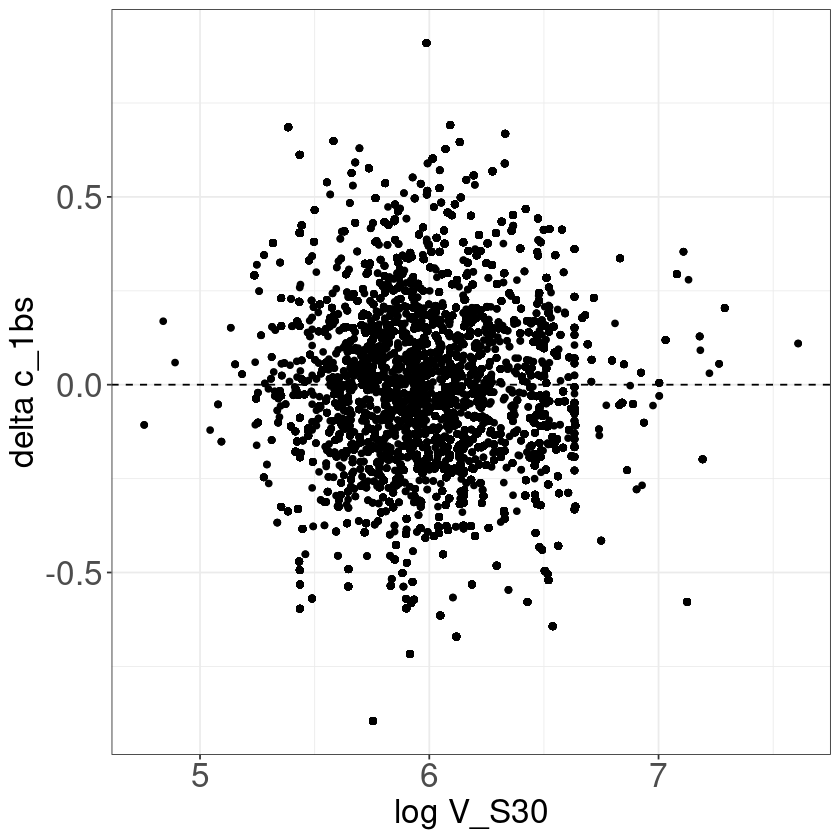

In [7]:
#spatially varying earthquake adjustment
pl_dc1e_mu_mag <- ggplot(df_coeff, aes(mag, dc_1e_mean)) + theme_bw() +
                    geom_point() + geom_hline(yintercept=0,linetype="dashed") +
                    geom_smooth(se = TRUE, formula = y ~ x, method = 'loess') +
                    labs(x='magnitude', y='delta c_1e') + 
                    theme(axis.title = element_text(size=20), 
                          axis.text.y = element_text(size=20), axis.text.x = element_text(size=20))

#spatially varying site adjustment
pl_dc1as_mu_vs30 <- ggplot(df_coeff, aes(log(Vs30), dc_1as_mean)) + theme_bw() +
                      geom_point() + geom_hline(yintercept=0,linetype="dashed") +
                      geom_smooth(se = TRUE, formula = y ~ x, method = 'loess') +
                      labs(x='log V_S30', y='delta c_1as') + 
                      theme(axis.title = element_text(size=20), 
                            axis.text.y = element_text(size=20), axis.text.x = element_text(size=20))

#spatially independent site adjustment
pl_dc1bs_mu_vs30 <- ggplot(df_coeff, aes(log(Vs30), dc_1bs_mean)) + theme_bw() +
                      geom_point() + geom_hline(yintercept=0,linetype="dashed") +
                      geom_smooth(se = TRUE, formula = y ~ x, method = 'loess') +
                      labs(x='log V_S30', y='delta c_1bs') + 
                      theme(axis.title = element_text(size=20), 
                            axis.text.y = element_text(size=20), axis.text.x = element_text(size=20))

print(pl_dc1e_mu_mag)
print(pl_dc1as_mu_vs30)
print(pl_dc1bs_mu_vs30)

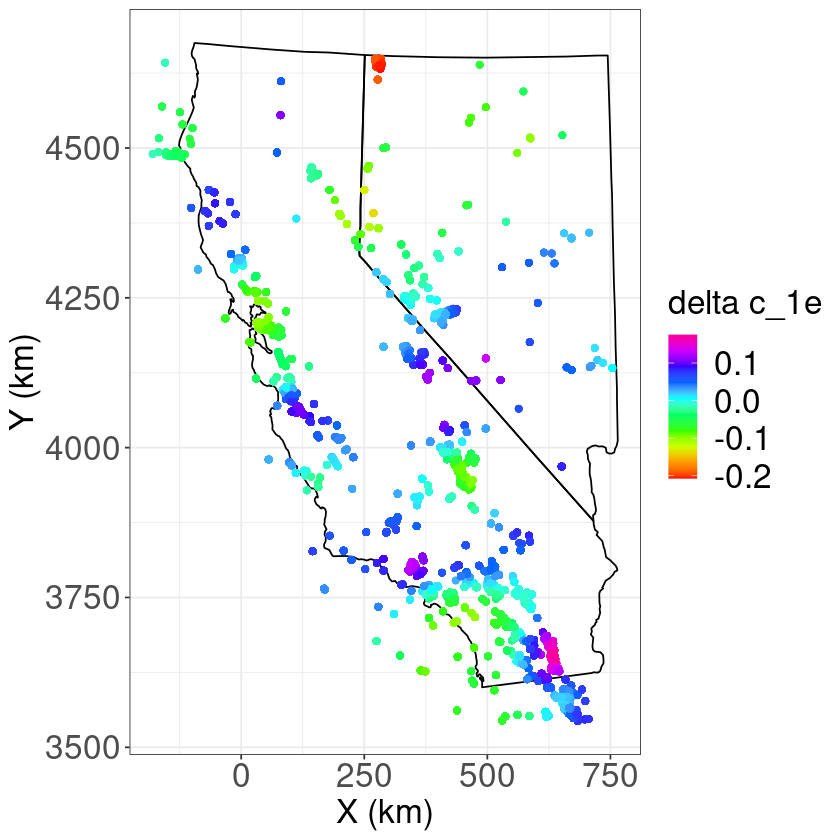

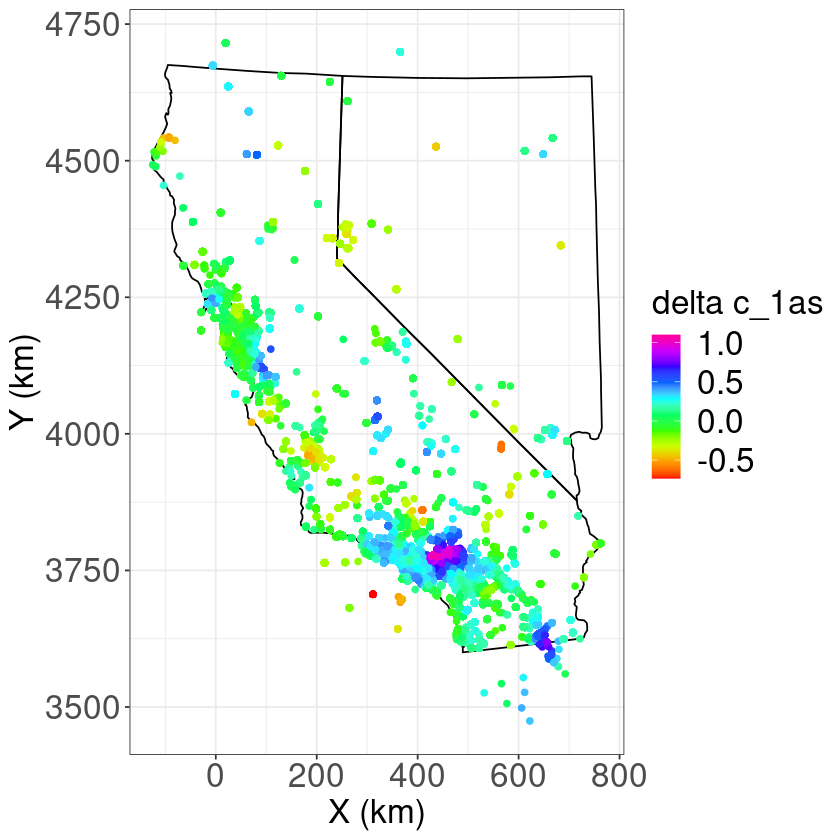

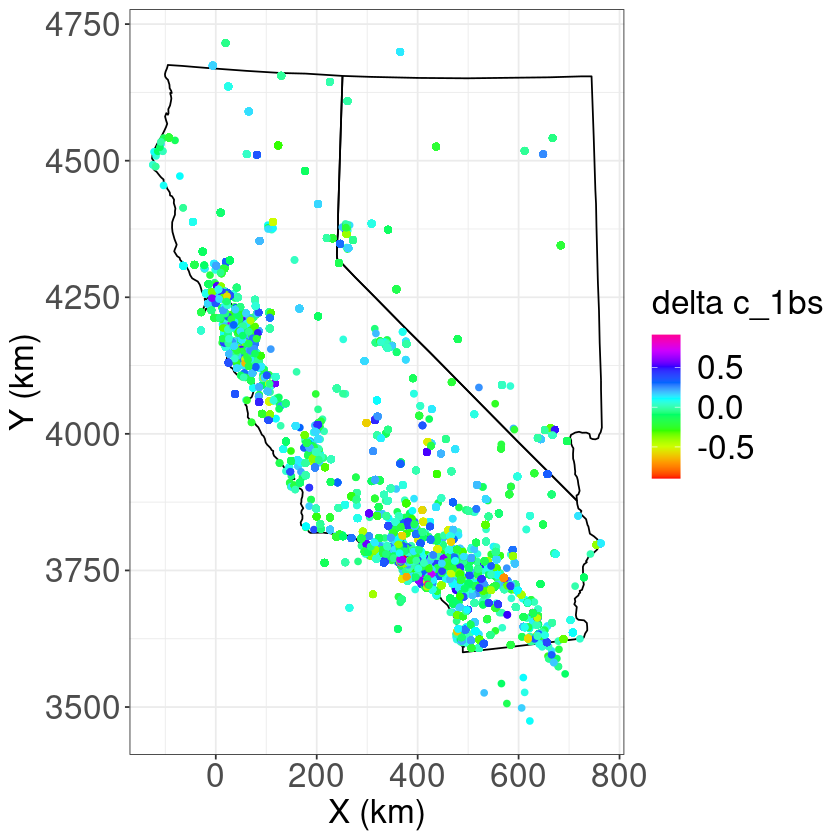

In [8]:
#UTM zone
utm_zone <- unique(df_flatfile$UTMzone)
utm_no   <- as.numeric(gsub("([0-9]+).*$", "\\1", utm_zone))
#California
map_ca     <- subset( map_data("state"), region %in% c("california"))
map_ca_utm <- LongLatToUTM(lat=map_ca$lat, lon=map_ca$long, utm_no)
map_ca[,c('X','Y')] <- map_ca_utm[,c('X','Y')]/1000
#Nevada
map_nv     <- subset( map_data("state"), region %in% c("nevada"))
map_nv_utm <- LongLatToUTM(lat=map_nv$lat, lon=map_nv$long, utm_no)
map_nv[,c('X','Y')] <- map_nv_utm[,c('X','Y')]/1000

#base map
pl_map <- ggplot() + theme_bw() +
            geom_path(data=map_ca, aes(x=X,y=Y), color='black') + 
            geom_path(data=map_nv, aes(x=X,y=Y), color='black')

#spatially varying earthquake adjustment
pl_dc1e_map <- pl_map + geom_point(data=df_coeff, aes(eqX, eqY, color=dc_1e_mean)) +
                  scale_color_gradientn(colours = rainbow(10)) +
                  labs(x='X (km)', y='Y (km)', color='delta c_1e') + 
                  theme(axis.title = element_text(size=20), 
                        axis.text.y = element_text(size=20), axis.text.x = element_text(size=20),
                        legend.text=element_text(size=20), legend.title=element_text(size=20))

#spatially varying site adjustment
pl_dc1as_map <- pl_map + geom_point(data=df_coeff, aes(staX, staY, color=dc_1as_mean)) +
                  scale_color_gradientn(colours = rainbow(10)) +
                  labs(x='X (km)', y='Y (km)', color='delta c_1as') + 
                  theme(axis.title = element_text(size=20), 
                        axis.text.y = element_text(size=20), axis.text.x = element_text(size=20),
                        legend.text=element_text(size=20), legend.title=element_text(size=20))

#spatially independent site adjustment
pl_dc1bs_map <- pl_map + geom_point(data=df_coeff, aes(staX, staY, color=dc_1bs_mean)) +
                  scale_color_gradientn(colours = rainbow(10)) +
                  labs(x='X (km)', y='Y (km)', color='delta c_1bs') + 
                  theme(axis.title = element_text(size=20), 
                        axis.text.y = element_text(size=20), axis.text.x = element_text(size=20),
                        legend.text=element_text(size=20), legend.title=element_text(size=20))

print(pl_dc1e_map)
print(pl_dc1as_map)
print(pl_dc1bs_map)

### Cell-specific Anelastic Attenuation

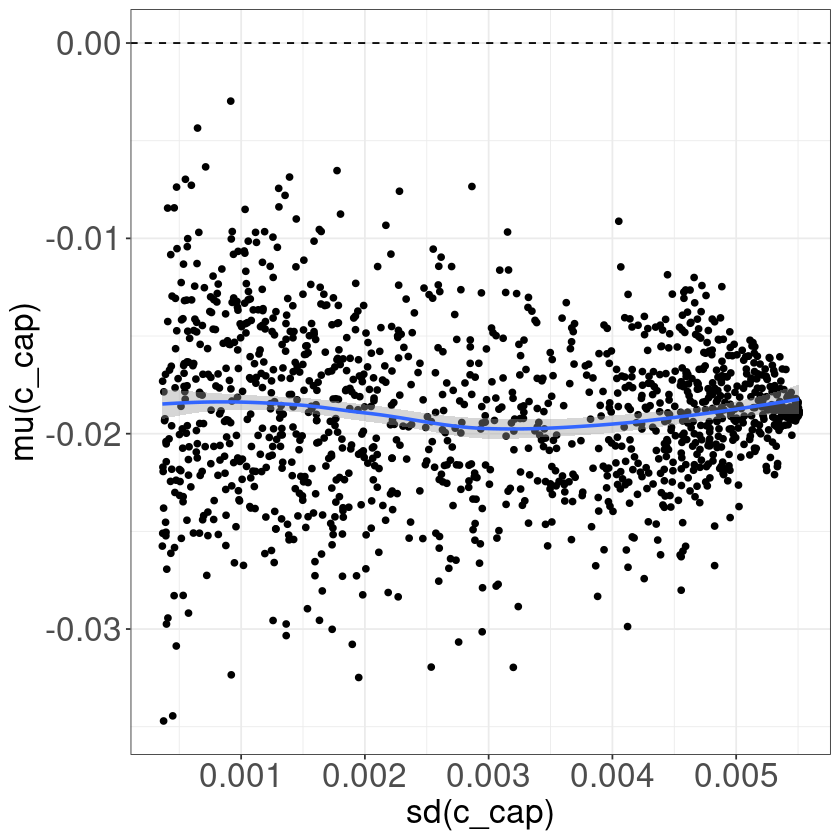

In [9]:
#cell-specific anelastic attenuation: mean versus std 
pl_c_cap <- ggplot(df_atten, aes(c_cap_sig, c_cap_mean)) + theme_bw() +
                geom_point() +
                labs(x='sd(c_cap)', y='mu(c_cap)') + 
                theme(axis.title = element_text(size=20), 
                      axis.text.y = element_text(size=20), axis.text.x = element_text(size=20))

print(pl_c_cap)

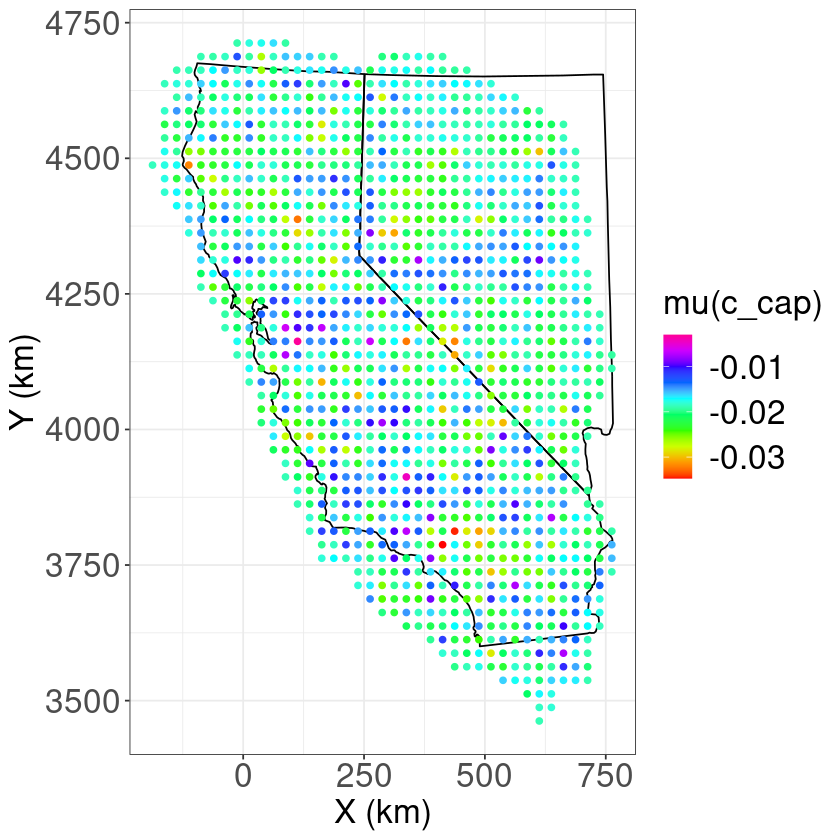

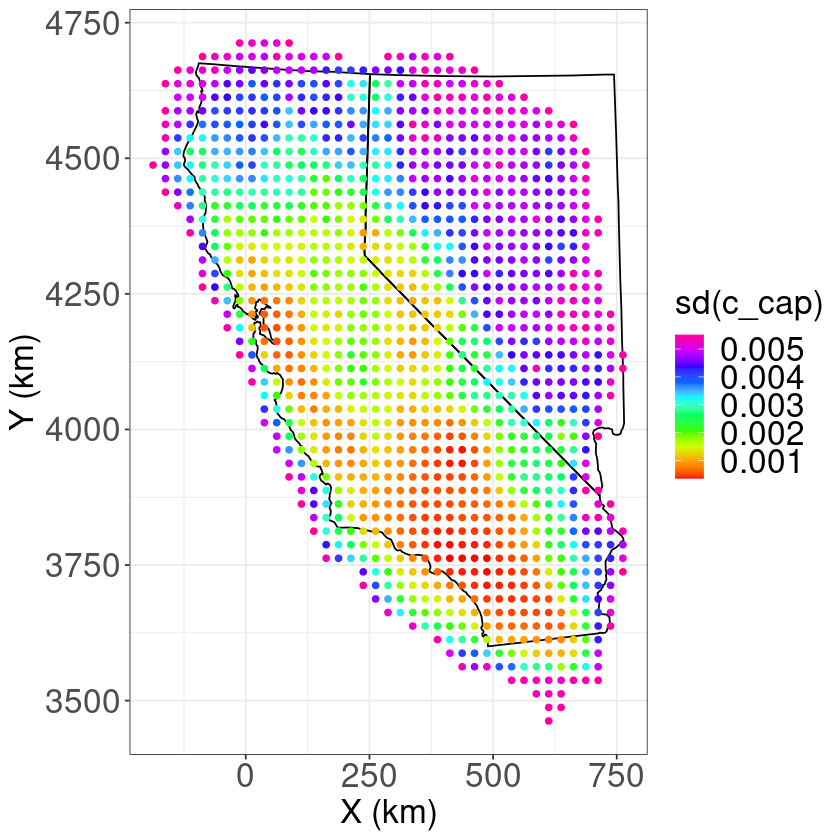

In [10]:
#cell-specific anelastic attenuation map
#mean
pl_c_cap_mu_map <- pl_map + geom_point(data=df_atten, aes(mptX, mptY, color=c_cap_mean)) +
                      scale_color_gradientn(colours = rainbow(10)) +
                      labs(x='X (km)', y='Y (km)', color='mu(c_cap)') + 
                      theme(axis.title = element_text(size=20), 
                            axis.text.y = element_text(size=20), axis.text.x = element_text(size=20),
                            legend.text=element_text(size=20), legend.title=element_text(size=20))
#std
pl_c_cap_sd_map <- pl_map + geom_point(data=df_atten, aes(mptX, mptY, color=c_cap_sig)) +
                      scale_color_gradientn(colours = rainbow(10)) +
                      labs(x='X (km)', y='Y (km)', color='sd(c_cap)') + 
                      theme(axis.title = element_text(size=20), 
                            axis.text.y = element_text(size=20), axis.text.x = element_text(size=20),
                            legend.text=element_text(size=20), legend.title=element_text(size=20))

print(pl_c_cap_mu_map)
print(pl_c_cap_sd_map)